In [7]:
pip install mpi4py

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
import time
import multiprocessing
from multiprocessing import Pool, Pipe
import os
import matplotlib.pyplot as plt
import threading
from mpi4py import MPI

In [9]:
data = pd.read_csv('20K_Datapoints.csv')
data

,X,Y
0,0.387717,10.746281
1,4.377074,227.190272
2,0.436813,22.670695
3,3.278660,177.120957
4,5.734753,373.677893
...,...,...
19995,8.228528,744.944460
19996,3.036068,137.230401
19997,2.874888,112.618173
19998,3.993018,236.503574


In [10]:
X = data.iloc[:, 0].to_numpy()
Y = data.iloc[:, 1].to_numpy()

Non-linear Regression

9.502181674800925 11.861262607997416 10.75668020578724


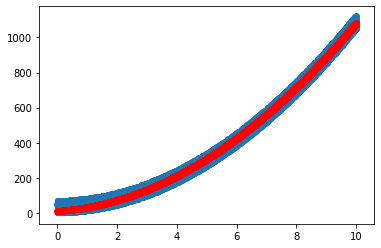

In [11]:
# Building the model
a = 0
b = 0
c = 0

L = 0.0001  # The learning Rate
epochs = 10000  # The number of iterations to perform gradient descent

n = float(len(X)) # Number of elements in X

# Performing Gradient Descent 
for i in range(epochs): 
    Y_pred = a*X*X + b*X + c  # The current predicted value of Y
    D_a = (-2/n) * sum(X*X * (Y - Y_pred))  # Derivative wrt a
    D_b = (-2/n) * sum(X * (Y - Y_pred))  # Derivative wrt b
    D_c = (-2/n) * sum(Y - Y_pred)  # Derivative wrt c
    a = a - L * D_a  # Update a
    b = b - L * D_b  # Update b
    c = c - L * D_c  # Update c

print (a, b, c)

# Making predictions
Y_pred = a*X*X + b*X + c

plt.scatter(X, Y)
plt.scatter(X, Y_pred , color='red') # predicted
plt.show()

Multithreading

In [12]:
def gradD(connection):
    a = 0
    b = 0
    c = 0
    L = .0001
    epochs = 10000
    x = connection.recv()
    y = connection.recv()
    n = float(len(x))
    for i in range(epochs):
        Y_pred = np.dot(a, np.multiply(x, x)) + np.dot(b, x) + c  # The current predicted value of Y
        D_a = np.dot(np.divide(-2, n), np.dot(np.multiply(x, x), np.subtract(y, Y_pred)))  # Derivative wrt a
        D_b = np.dot(np.divide(-2, n), np.dot(x, np.subtract(y, Y_pred)))  # Derivative wrt b
        D_c = np.dot(np.divide(-2, n), np.sum(np.subtract(y, Y_pred)))  # Derivative wrt c
        a = np.subtract(a, np.dot(L, D_a))  # Update a
        b = np.subtract(b, np.dot(L, D_b))  # Update b
        c = np.subtract(c, np.dot(L, D_c))  # Update c
    connection.send(a)
    connection.send(b)
    connection.send(c)

In [13]:
if __name__ == '__main__':
    split = 2
    startTime = time.time()
    parentConnection, childConnection = Pipe()
    X = np.array_split(X, split)
    Y = np.array_split(Y, split)
    for i in range(split):
        thread = threading.Thread(target=gradDesc, args=(childConnection,))
        print(thread)
        thread.start()
        parentConnection.send(X[i])
        parentConnection.send(Y[i])
        time.sleep(0.1)
    a = parentConnection.recv()
    b = parentConnection.recv()
    c = parentConnection.recv()
    print("A: ", a, "B: ", b, "C: ", c)
    print('That took {} seconds'.format(time.time() - startTime))

<Thread(Thread-6, initial)>
<Thread(Thread-7, initial)>
A:  9.504485997947771 B:  11.885450954728851 C:  10.75605846863418
That took 4.620450735092163 seconds


MPI

In [5]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
numProcs = comm.Get_size()

L = 0.0001  # The learning Rate
epochs = 10000  # The number of iterations to perform gradient descent

a = 0
b = 0
c = 0

n = float(len(data))

def gradD(data, parameters):
    a, b, c = [p for p in parameters]
    X = data.iloc[:, 0].to_numpy()
    Y = data.iloc[:, 1].to_numpy()
    Y_pred = np.dot(a, np.multiply(X, X)) + np.dot(b, X) + c  # The current predicted value of Y
    D_a = np.dot(np.divide(-2, n), np.dot(np.multiply(X, X), np.subtract(Y, Y_pred)))  # Derivative wrt a
    D_b = np.dot(np.divide(-2, n), np.dot(X, np.subtract(Y, Y_pred)))  # Derivative wrt b
    D_c = np.dot(np.divide(-2, n), np.sum(np.subtract(Y, Y_pred)))  # Derivative wrt c
    return [D_a, D_b, D_c]

In [6]:
if __name__ == '__main__':
    startTime = time.time()

    for i in range(epochs):
        if rank == 0:
            splitData = np.array_split(data, numProcs)
            parameters = [a, b, c]
        else:
            splitData = None
            parameters = None

        parameters = comm.bcast(parameters, root=0)
        dataScatter = comm.scatter(splitData, root=0)
        gradients = gradDesc(dataScatter, parameters)
        gradients = comm.gather(gradients, root=0)

        if rank == 0:
            D_a, D_b, D_c = [np.sum(k) for k in zip(*gradients)]
            a = np.subtract(a, np.dot(L, D_a))  # Update a
            b = np.subtract(b, np.dot(L, D_b))  # Update b
            c = np.subtract(c, np.dot(L, D_c))  # Update c

    if rank == 0:
        print('MPI:')
        print("A: ", a, "B: ", b, "C: ", c)
        print('That took {} seconds'.format(time.time() - startTime))

MPI:
A:  9.502181674800925 B:  11.861262607997412 C:  10.756680205787251
That took 13.093668222427368 seconds
